In [40]:
import xcast as xc
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

In [48]:
# setup the folder where you want to work for this project
# either type in the location, or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()
project_dir = os.getcwd()#"/Users/katie/Desktop/trial_pacisl" 

#make subdirectores to organize your work within the project if they don't already exist
data_dir = os.path.join(project_dir, 'practical_data')
nc_dir = os.path.join(data_dir, 'nc_files')

obs_types = ['CMORPH', 'UCSB0p05']
training_length = 'three_seas'

In [42]:
initial_dates = [(2023, 7,1), (2023, 8, 1), (2023, 9, 1), (2023, 10, 1), (2023, 11,1), (2023, 12,1),
                 (2024, 1, 1), (2024, 2, 1), (2024, 3, 1), (2024, 4, 1), (2024, 5, 1), (2024, 6, 1)]

In [43]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

coordinate_conversion = {
    'latitude': 'Y',
    'lat': 'Y',
    'Y': 'Y',
    'longitude': 'X',
    'lon': 'X',
    'X': 'X',
    'time': 'T',
    'year': 'T',
    'season': 'season',
    'T': 'T'
}

In [44]:
initial_date = initial_dates[8]
obs_name = obs_types[0]
gcms = ['NMME']

In [45]:
leads = [['1', '3'],['2', '4'], ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_months = []
target_seas = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_mid = number_to_month_name_dictionary[(initial_month + float(l[0])+1)%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_seas.append('-'.join([target_low, target_high]))
    target_months.append(target_low[0] + target_mid[0] + target_high[0])
print('Target seasons to forecast')
print(target_seas)

Target seasons to forecast
['Apr-Jun', 'May-Jul', 'Jun-Aug']


In [46]:
#make sure all coordinate names follow the naming conventions set up in coordinate dictionary
def prep_names(ds, coordinate_conversion):
    og_coords = list(ds.coords)
    for o in og_coords:
        ds = ds.rename({o:coordinate_conversion[o]})
    return ds

#check if all leads have the same number of years
def check_leads_years(ds_list):
    nyears = []
    for ds in ds_list:
        nyears.append(len(np.unique(ds.S.values)))
    return  all(i==nyears[0] for i in nyears)

#check all years are available for all lead times in hindcast period, only keep intersecting years
def keep_intersecting_years(ds_list):
    if check_leads_years(ds_list) == True:
        ds_update = xr.concat(ds_list, dim = 'L')
    else:
        unique_years = []
        for ds in ds_list:
            base = ds.swap_dims({'S':'T'}).to_dataset(name = 'prec')
            unique_years.append(np.unique(base.T.dt.year.values))
        intersecting_years = [x for x in unique_years[0] if x in unique_years[1] and x in unique_years[2]]

        ds_update = []
        for ds in ds_list:
            ds_check = ds.swap_dims({'S':'T'}).to_dataset(name = 'prec')
            ds_update.append(ds_check.sel(T=ds_check.T.dt.year.isin(intersecting_years)).swap_dims({'T':'S'}).prec)
        ds_update = xr.concat(ds_update, dim = 'L')
    return ds_update

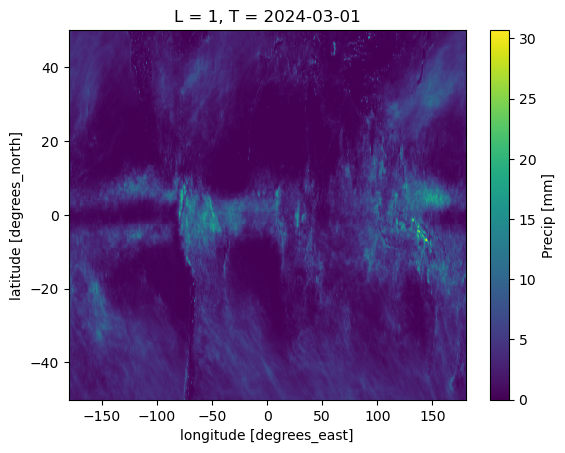

In [55]:
obs_leads = []
for t, target in enumerate(target_months):
    if obs_name == 'CMORPH':
        obs_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + str(t + 1), obs_name]))
    elif 'UCSB' in obs_name:
        obs_file = '{}*.nc'.format('_'.join([target, obs_name, 'pac-islands']))
        
    Y_raw = xr.open_dataset(glob.glob(os.path.join(nc_dir, obs_file))[0])
    Y = prep_names(Y_raw, coordinate_conversion)
    Y = getattr(Y, [i for i in Y.data_vars][0])
    Y = Y.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    obs_leads.append(Y)
obs_leads = keep_intersecting_years(obs_leads)
obs_leads.isel(L=0,S=0).plot()
obs_leads.to_netcdf(os.path.join(nc_dir, 'prepped_obs'))

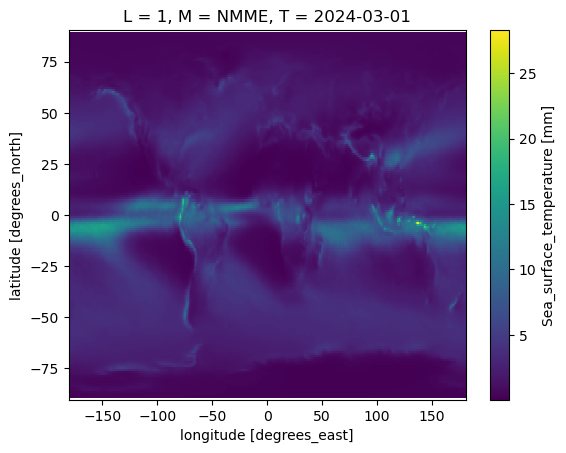

In [54]:
# read in hindcast and forecast data
hindcast_data, forecast_data = [], []
for t, target in enumerate(target_months):
    hindcast_data_l, forecast_data_l = [], []
    for gcm in gcms:
        gcm_hindcast_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + leads[t][0], training_length, gcm, 'hind']))
        gcm_forecast_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + leads[t][0], training_length, gcm, 'fcst']))
        g = xr.open_dataset(glob.glob(os.path.join(nc_dir, gcm_hindcast_download_file))[0])
        f = xr.open_dataset(glob.glob(os.path.join(nc_dir, gcm_forecast_download_file))[0])
        g = prep_names(g, coordinate_conversion).expand_dims({'M':[gcm]})
        f = prep_names(f, coordinate_conversion).expand_dims({'M':[gcm]})
        hindcast_data_l.append(g)
        forecast_data_l.append(f)
    hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
    forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
    hindcast_data_l = hindcast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    forecast_data_l = forecast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    hindcast_data.append(hindcast_data_l)
    forecast_data.append(forecast_data_l)

#create one dataset across all lead times of interest
forecast_data = xr.concat(forecast_data, dim = 'L')
#check all hindcast years are available for all lead times and only keep dataset with intersecting years
hindcast_data = keep_intersecting_years(hindcast_data)
hindcast_data.isel(L=0,S=0).precip.plot()
forecast_data.to_netcdf(os.path.join(nc_dir, 'prepped_fcst_data'))
hindcast_data.to_netcdf(os.path.join(nc_dir, 'prepped_hcst_data'))